In [1]:
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore, BayesianEstimator

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

import tensorflow as tf

sns.set(style='whitegrid', rc={'figure.figsize':(10,6)})
plt.rcParams['figure.figsize'] = (12, 8)

RAW_DIR       = os.path.join('..', 'data', 'raw')
PROCESSED_DIR = os.path.join('..', 'data', 'processed')
os.makedirs(PROCESSED_DIR, exist_ok=True)


In [2]:
wind       = xr.open_dataset(os.path.join(RAW_DIR, 'cdsWind.nc'))
currents   = xr.open_dataset(os.path.join(RAW_DIR, 'cmems_mod_glo_phy_anfc_merged-uv_PT1H-i_1748321230089.nc'))
bathymetry = xr.open_dataset(os.path.join(RAW_DIR, 'gebco_2024.nc'))

print("Vent:", wind)
print("Courants:", currents)
print("Bathymétrie:", bathymetry)


Vent: <xarray.Dataset>
Dimensions:     (valid_time: 744, latitude: 3, longitude: 5)
Coordinates:
    number      int64 ...
  * valid_time  (valid_time) datetime64[ns] 2024-05-01 ... 2024-05-31T23:00:00
  * latitude    (latitude) float64 34.0 33.75 33.5
  * longitude   (longitude) float64 -7.5 -7.25 -7.0 -6.75 -6.5
    expver      (valid_time) object ...
Data variables:
    u10         (valid_time, latitude, longitude) float32 ...
    v10         (valid_time, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-27T18:11 GRIB to CDM+CF via cfgrib-0.9.1...
Courants: <xarray.Dataset>
Dimensions:    (time: 17544, depth: 1, latitude: 19, longitude: 24)
Coordinates:
  * time       (time) datetime64[ns] 2023-

In [3]:
# 3.1 Surface des courants
currents_surf = currents.sel(depth=currents.depth.min())

# 3.2 Interpolation nearest
curr2wind = currents_surf.sel(
    time=wind.valid_time,
    latitude=wind.latitude,
    longitude=wind.longitude,
    method='nearest'
)
bath2wind = bathymetry.sel(
    lat=wind.latitude,
    lon=wind.longitude,
    method='nearest'
)

# 3.3 Construction du Dataset xarray
ds = xr.Dataset({
    'u10':      (wind.u10.dims,     wind.u10.data),
    'v10':      (wind.v10.dims,     wind.v10.data),
    'u_curr':   (curr2wind.uo.dims, curr2wind.uo.data),
    'v_curr':   (curr2wind.vo.dims, curr2wind.vo.data),
    'elevation':(bath2wind.elevation.dims, bath2wind.elevation.data),
}, coords={
    'time':     wind.valid_time,
    'latitude': wind.latitude,
    'longitude':wind.longitude
})

# 3.4 Passage en DataFrame & nettoyage
df = ds.to_dataframe().reset_index().rename(columns={'valid_time':'time'})
df = df.drop(columns=['number','expver'], errors='ignore')
for col in ['u_curr','v_curr','elevation']:
    df[col].fillna(df[col].median(), inplace=True)

print(" df prêt, shape =", df.shape)


 df prêt, shape = (11160, 9)


C:\Users\zaineb\AppData\Local\Temp\ipykernel_10992\2545503415.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\zaineb\AppData\Local\Temp\ipykernel_10992\2545503415.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

                u10           v10        u_curr        v_curr     elevation
count  11160.000000  11160.000000  11160.000000  11160.000000  11160.000000
mean       0.461223     -2.081515     -0.245634     -0.095746    144.933333
std        1.441599      1.977641      0.083277      0.054555    181.685681
min       -5.131012     -8.649002     -0.687500     -0.385742   -120.000000
25%       -0.480019     -3.407043     -0.244141     -0.094727    -60.000000
50%        0.449043     -1.995605     -0.244141     -0.094727    166.000000
75%        1.408913     -0.707081     -0.244141     -0.094727    237.000000
max        6.438583      2.940247      0.205078      0.147461    530.000000


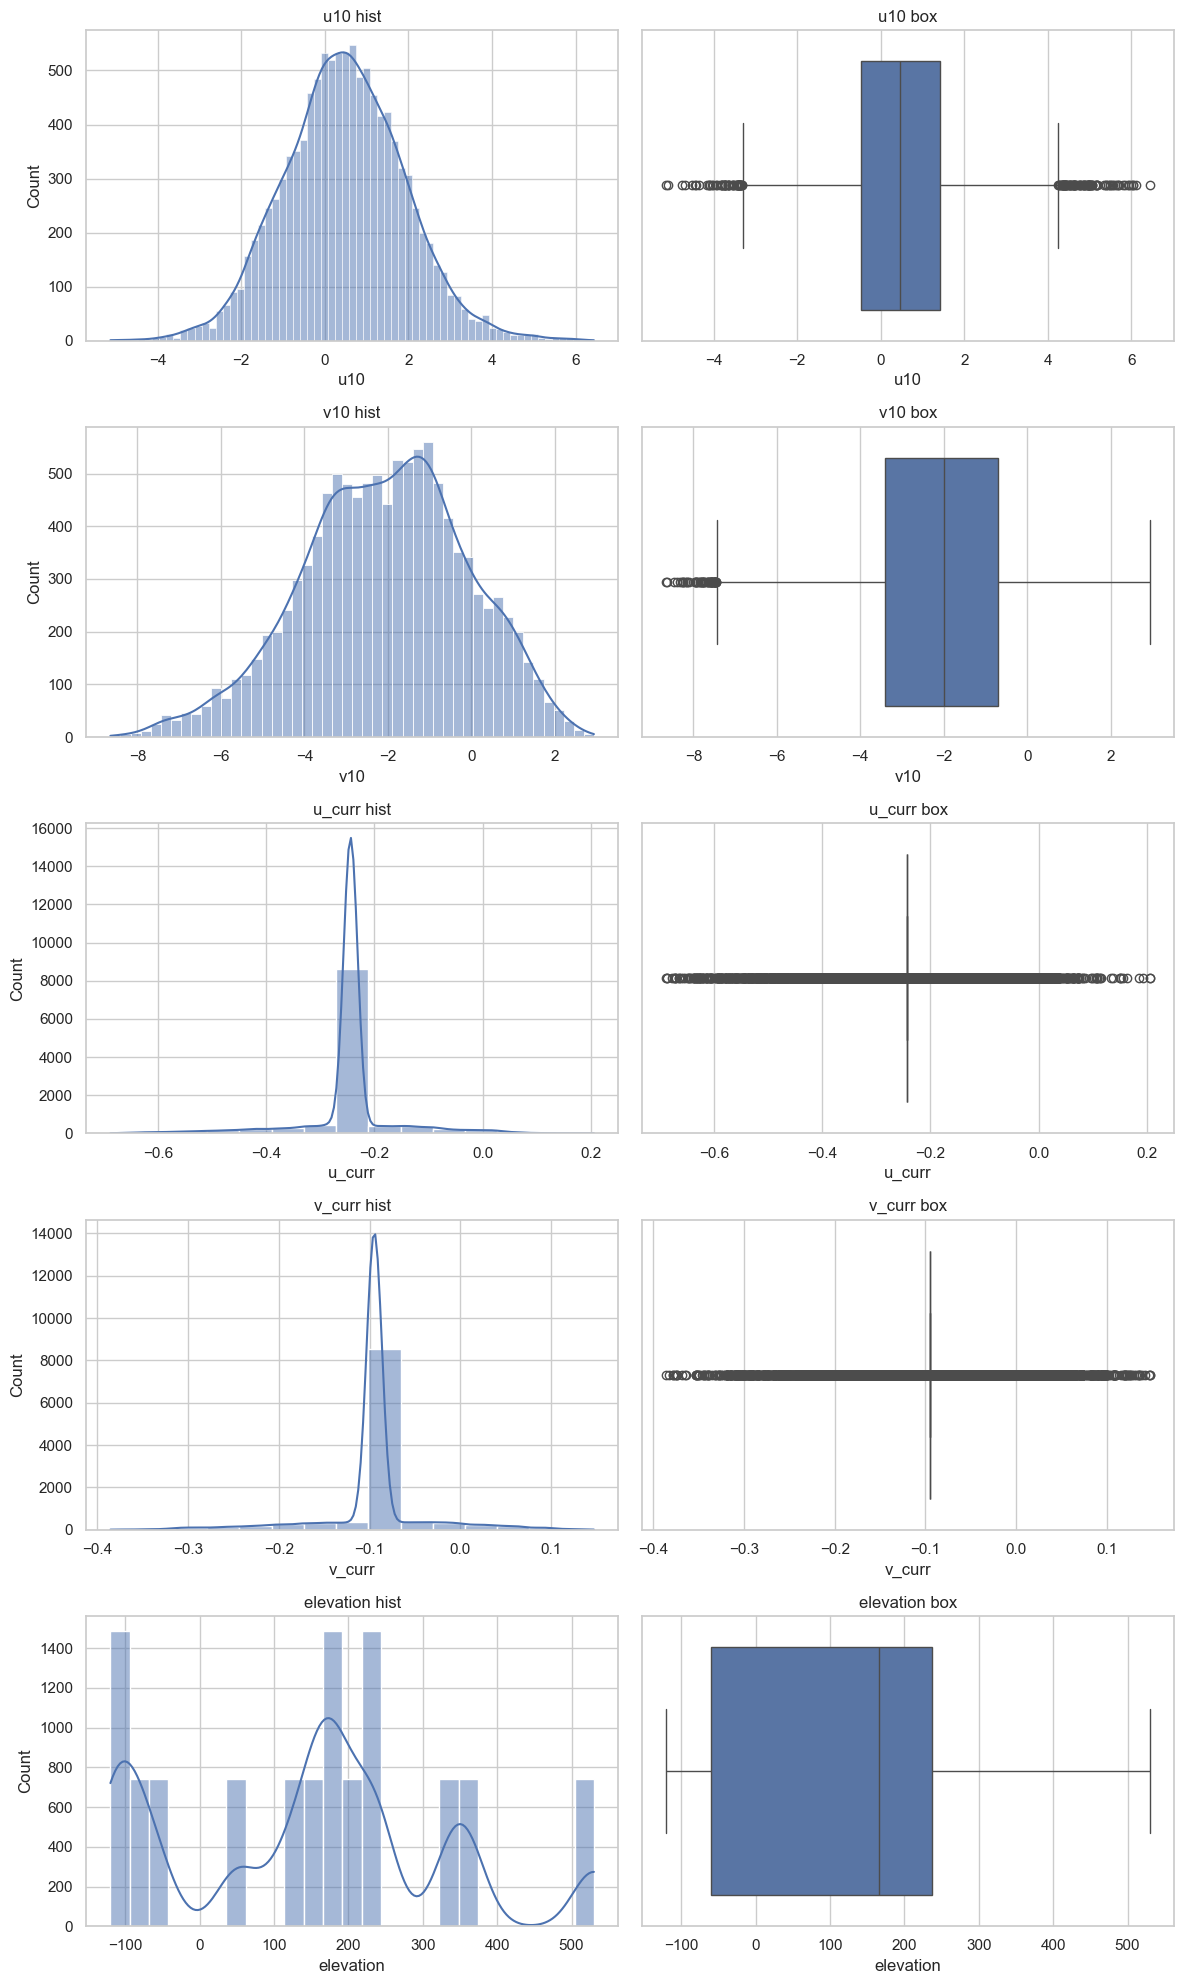


Corrélation :
                 u10       v10    u_curr    v_curr  elevation
u10        1.000000  0.075878  0.199915 -0.067230  -0.050715
v10        0.075878  1.000000  0.270012  0.285269   0.240808
u_curr     0.199915  0.270012  1.000000  0.203922   0.059331
v_curr    -0.067230  0.285269  0.203922  1.000000   0.031680
elevation -0.050715  0.240808  0.059331  0.031680   1.000000


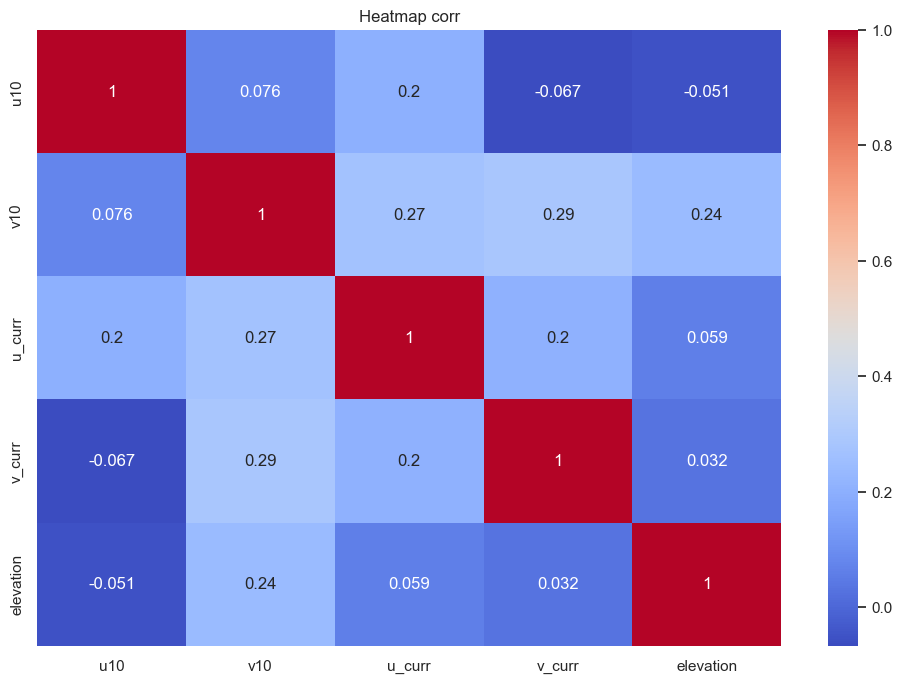

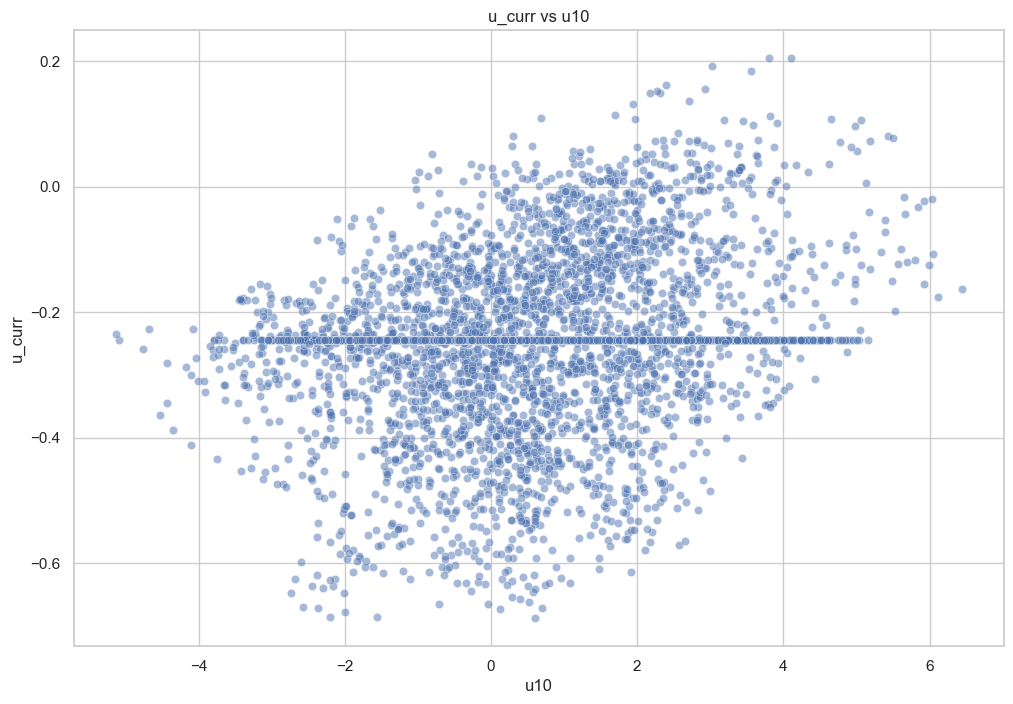

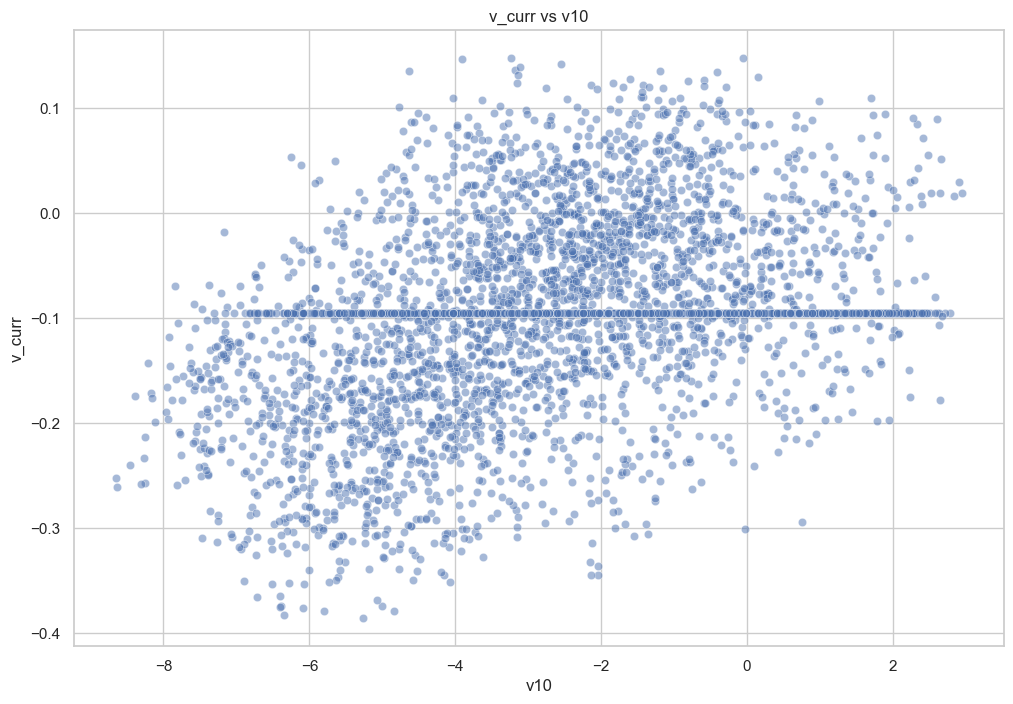

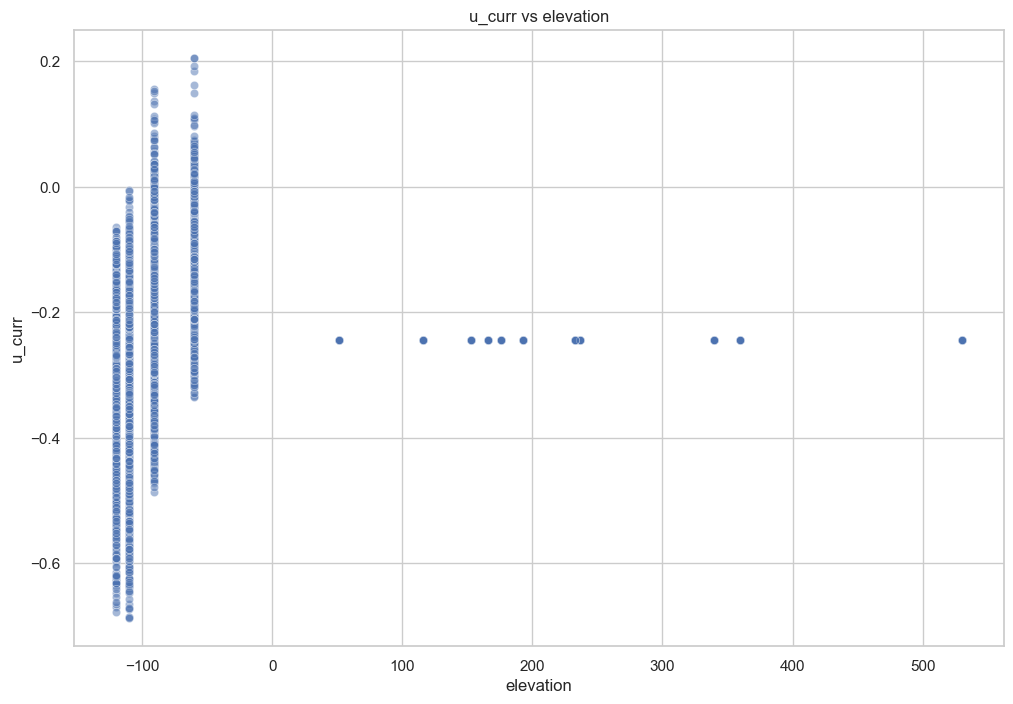

In [4]:
vars_ = ['u10','v10','u_curr','v_curr','elevation']

# Univarié
print(df[vars_].describe())

# Histos & boxplots
fig, axes = plt.subplots(len(vars_), 2, figsize=(12,4*len(vars_)))
for i, col in enumerate(vars_):
    sns.histplot(df[col], ax=axes[i,0], kde=True).set_title(f"{col} hist")
    sns.boxplot(x=df[col], ax=axes[i,1]).set_title(f"{col} box")
plt.tight_layout(); plt.show()

# Corrélations
corr = df[vars_].corr()
print("\nCorrélation :\n", corr)
sns.heatmap(corr, annot=True, cmap='coolwarm').set_title("Heatmap corr")
plt.show()

# Scatter clés
for x,y in [('u10','u_curr'),('v10','v_curr'),('elevation','u_curr')]:
    sns.scatterplot(data=df, x=x, y=y, alpha=0.5).set_title(f"{y} vs {x}")
    plt.show()


In [5]:
# Outliers capés (1–99%)
for col in ['u10','v10']:
    low, high = df[col].quantile([0.01,0.99])
    df[col] = df[col].clip(low, high)

# Définir target
df['target'] = (df['u10'] > df['u10'].quantile(0.75)).astype(int)
print("Target balance:\n", df['target'].value_counts())

# SMOTE (optionnel)
from imblearn.over_sampling import SMOTE
X_sm, y_sm = SMOTE(random_state=42).fit_resample(
    df[['v10','u_curr','v_curr','elevation']], df['target']
)
print("Après SMOTE:\n", pd.Series(y_sm).value_counts())


Target balance:
 target
0    8370
1    2790
Name: count, dtype: int64
Après SMOTE:
 target
1    8370
0    8370
Name: count, dtype: int64


In [ ]:
# 5B. SMOTE + reconstruction du DataFrame prétraité

from imblearn.over_sampling import SMOTE
import pandas as pd

# 1) Sélection des features et de la cible
X_sm = df[['v10','u_curr','v_curr','elevation']]
y_sm = df['target']

# 2) Application de SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_sm, y_sm)

# 3) Reconstruction du DataFrame
df_pre = pd.concat([
    pd.DataFrame(X_res, columns=X_sm.columns),
    pd.Series(y_res, name='target')
], axis=1)

print("✔️ df_pre shape :", df_pre.shape)
print(df_pre['target'].value_counts())

# (Optionnel) Sauvegarde du DataFrame prétraité
# df_pre.to_csv(os.path.join(PROCESSED_DIR, 'df_pre_smote.csv'), index=False)


NameError: name 'X_res' is not defined